In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import ipywidgets as widgets
from IPython.display import display

#### Note that beyond the basic example most of this notebook is just reference

## Basic Example

Since button clicks are stateless, they are transmitted from the front-end to the back-end using custom messages. By using the `on_click` method, a button that prints a message when it has been clicked is shown below. To capture prints (or any other kind of output) and ensure it is displayed, be sure to send it to an `Output` widget (or put the information you want to display into an HTML widget).

In [ ]:
button = widgets.Button(description="Click Me!")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        print("Button clicked.")

button.on_click(on_button_clicked)

Button(description='Click Me!', style=ButtonStyle())

Output()

### Create a callback that watches a widget for value changes 

In [ ]:
int_range = widgets.IntSlider()
output2 = widgets.Output()

display(int_range, output2)

def on_value_change(change):
    with output2:
        print(change['new'])

int_range.observe(on_value_change, names='value')

IntSlider(value=0)

Output()

## Linking two widgets (Reference Only)
NB 01_Widgets_list shows how to link two widgets using widgets.jslink and the syntax below, it appears there
are two others, link and dlink that have to do with traitlets but im not sure how they are different

In [ ]:
caption = widgets.Label(value='The values of slider1 and slider2 are synchronized')
sliders1, slider2 = widgets.IntSlider(description='Slider 1'),\
                    widgets.IntSlider(description='Slider 2')
l = widgets.link((sliders1, 'value'), (slider2, 'value'))
display(caption, sliders1, slider2)

Label(value='The values of slider1 and slider2 are synchronized')

IntSlider(value=0, description='Slider 1')

IntSlider(value=0, description='Slider 2')

In [ ]:
caption = widgets.Label(value='Changes in source values are reflected in target1')
source, target1 = widgets.IntSlider(description='Source'),\
                  widgets.IntSlider(description='Target 1')
dl = widgets.dlink((source, 'value'), (target1, 'value'))
display(caption, source, target1)

Label(value='Changes in source values are reflected in target1')

IntSlider(value=0, description='Source')

IntSlider(value=0, description='Target 1')

In [ ]:
caption = widgets.Label(value='The values of range1 and range2 are synchronized')
slider = widgets.IntSlider(min=-5, max=5, value=1, description='Slider')

def handle_slider_change(change):
    caption.value = 'The slider value is ' + (
        'negative' if change.new < 0 else 'nonnegative'
    )

slider.observe(handle_slider_change, names='value')

display(caption, slider)

Label(value='The values of range1 and range2 are synchronized')

IntSlider(value=1, description='Slider', max=5, min=-5)

## Linking in kernel vs client
### Kernel only works if python is running so nbviewer tutorials may need jslink

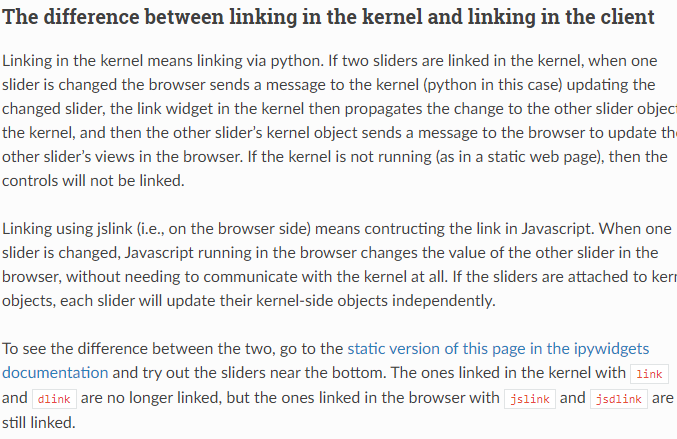

## Advaned ways to slow down event calls on continuous sliders/textareas

#### Debouncing, ignores function calls if a certain amount of time hasnt passed

In [ ]:
import asyncio

class Timer:
    def __init__(self, timeout, callback):
        self._timeout = timeout
        self._callback = callback
        self._task = asyncio.ensure_future(self._job())

    async def _job(self):
        await asyncio.sleep(self._timeout)
        self._callback()

    def cancel(self):
        self._task.cancel()

def debounce(wait):
    """ Decorator that will postpone a function's
        execution until after `wait` seconds
        have elapsed since the last time it was invoked. """
    def decorator(fn):
        timer = None
        def debounced(*args, **kwargs):
            nonlocal timer
            def call_it():
                fn(*args, **kwargs)
            if timer is not None:
                timer.cancel()
            timer = Timer(wait, call_it)
        return debounced
    return decorator

slider = widgets.IntSlider()
text = widgets.IntText()

@debounce(0.2)
def value_changed(change):
    text.value = change.new
slider.observe(value_changed, 'value')

widgets.VBox([slider, text])

#### Throttling limits the rate of calls that are made

In [ ]:
import asyncio
from time import time

def throttle(wait):
    """ Decorator that prevents a function from being called
        more than once every wait period. """
    def decorator(fn):
        time_of_last_call = 0
        scheduled = False
        new_args, new_kwargs = None, None
        def throttled(*args, **kwargs):
            nonlocal new_args, new_kwargs, time_of_last_call, scheduled
            def call_it():
                nonlocal new_args, new_kwargs, time_of_last_call, scheduled
                time_of_last_call = time()
                fn(*new_args, **new_kwargs)
                scheduled = False
            time_since_last_call = time() - time_of_last_call
            new_args = args
            new_kwargs = kwargs
            if not scheduled:
                new_wait = max(0, wait - time_since_last_call)
                Timer(new_wait, call_it)
                scheduled = True
        return throttled
    return decorator

In [ ]:
slider = widgets.IntSlider()
text = widgets.IntText()

@throttle(0.2)
def value_changed(change):
    text.value = change.new
slider.observe(value_changed, 'value')

widgets.VBox([slider, text])